In [1]:
import networkx
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import *
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, ResGatedGraphConv, GATv2Conv, SAGEConv, GENConv, DeepGCNLayer, PairNorm, GINConv,GCNConv,NNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
pd.options.mode.use_inf_as_na = True
from collections import Counter
from sklearn.feature_selection import SelectFromModel
import torch.nn as nn
import time
import pickle
from torch.nn import LayerNorm, Linear, ReLU
from torch_scatter import scatter
from tqdm import tqdm
from torch_geometric.loader import RandomNodeSampler
import math
import copy
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
from torch_geometric.utils import dropout_adj

In [3]:
import warnings
# action参数可以设置为ignore，一位一次也不喜爱你是，once表示为只显示一次
warnings.filterwarnings(action='ignore')

In [4]:
# np.random.seed(0)
# torch.manual_seed(0)

In [5]:
class CNN1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNN1d,self).__init__()
        output_channels = 10
        padding = 0
        dilation = 1
        kernel_size = 3
        stride = 3
        output_size = int((output_channels * in_channels + 2 * padding - dilation * (kernel_size - 1) -1) / stride + 1)
        self.layer1 = nn.Sequential(
            nn.Conv1d(1,output_channels,kernel_size, padding='same'),
            nn.MaxPool1d(kernel_size, stride),
            nn.ReLU()
            )
        self.fc = nn.Linear(output_size,out_channels)
    def forward(self,x):
        x = x.view(x.size(0), 1, x.size(1))
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out


In [6]:
class Transition_layer(torch.nn.Module):
    def __init__(self, act, norm, lin):
        super().__init__()
        self.act = act
        self.norm = norm
        self.lin = lin
    def forward(self, x):
        x = self.norm(x)
        x = self.act(x)
        x = self.lin(x)
        return x
        
class DenseGAT(torch.nn.Module):
    def __init__(self, in_channels, num_class, num_layers=6, num_blocks=3, growth_rate=10, theta=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.blocks = num_blocks
        self.theta = theta
        self.growth_rate = growth_rate
        self.base_rate = growth_rate
        self.in_channels = in_channels
        self.out_channels = num_class
        self.linear_layers = torch.nn.ModuleList()
        self.transition_layers = torch.nn.ModuleList()
        self.block_layers = torch.nn.ModuleList()
        self.node_encoder = Linear(in_channels, growth_rate)
        self.linear_layers.append(self.node_encoder)
        
        for i in range(self.blocks):
            # block
            layers = torch.nn.ModuleList()
            # 2^(i - 1) * k0
            self.growth_rate = int(math.pow(2, i) * self.base_rate)
            print(self.growth_rate)
            for j in range(1, self.num_layers + 1):
                conv = SAGEConv(in_channels + (j - 1) * self.growth_rate, self.growth_rate, aggr='mean')
                norm = LayerNorm(self.growth_rate)
                act = ReLU()
                layer = DeepGCNLayer(conv, norm, act, block='dense')
                layers.append(layer)
            self.block_layers.append(layers)
            
            # transition
            hidden_channels = in_channels +  self.num_layers * self.growth_rate
            out_channels = int(hidden_channels * self.theta)
            transition_norm = LayerNorm(hidden_channels, elementwise_affine=True)
            transition_act = ReLU()
            transition_lin = Linear(hidden_channels, out_channels)
            transitionLayer = Transition_layer(transition_act, transition_norm, transition_lin)
            self.transition_layers.append(transitionLayer)
            in_channels = copy.copy(out_channels)
        
        self.lin_last = Linear(in_channels, self.out_channels)
        self.linear_layers.append(self.lin_last)
        
    def forward(self, x, edge_index):
#         x = self.linear_layers[0](x)
        for i in range(self.blocks):
            # block layer
            for layer in self.block_layers[i]:
                x = layer(x, edge_index)
            # transition layer
            x = self.transition_layers[i](x)
        x = self.linear_layers[-1](x)
        return x

In [7]:
from sklearn.utils import class_weight
def train():
    total_loss = total_correct = total_examples = 0
    start_time = time.time()
    for batch in train_loader:
        batch = batch.to(device)
        y = batch.y[:batch.batch_size]
        optimizer.zero_grad()
        y_hat = model(batch.x.to(device), batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
    end_time = time.time()  
    
    return total_loss / total_examples, total_correct / total_examples

def inferrence(model, subgraph_loader):
    total_loss = total_correct = total_examples = 0
    xs = []
    y = []
    pbar = tqdm(total=len(subgraph_loader))
    for batch in subgraph_loader:
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        xs.append(y_hat.cpu())
        y_true = batch.y[:batch.batch_size]
        y.append(y_true.cpu())
        pbar.update(1)
    pbar.close()
    y_hat = torch.cat(xs, 0)
    y_hat = y_hat.detach().numpy()
    y_hat = np.argmax(y_hat, -1)
    y = torch.cat(y, 0)
    cr1 = classification_report(y, y_hat, digits=4)
    cf = confusion_matrix(y, y_hat)
#     print(roc_auc_score(y, y_hat))
    print(cr1)
    print(cf)
    return  y, y_hat

def get_metrics(y_true, y_pred):
    cr = classification_report(y_true, y_pred, output_dict=True, digits=4)
    df = pd.DataFrame(cr).transpose()
    cm = confusion_matrix(y_true, y_pred)
    print(df)
    print(cm)

In [8]:
train_data = torch.load('unswnb_dgl_to_pyg_train_data')

In [9]:
test_data = torch.load('unswnb_dgl_to_pyg_test_data')

In [10]:
train_data,test_data

(Data(x=[358047, 40], y=[358047], edge_index=[2, 916065844], num_nodes=358047),
 Data(x=[153454, 40], y=[153454], edge_index=[2, 169209818], num_nodes=153454))

In [11]:
Counter(train_data.y.numpy())

Counter({3: 22894,
         2: 19582,
         1: 62334,
         0: 139925,
         4: 70000,
         9: 3748,
         6: 33944,
         8: 3260,
         5: 2116,
         7: 244})

In [12]:
Counter(test_data.y.numpy())

Counter({1: 26716,
         3: 9812,
         9: 1606,
         6: 14548,
         2: 8392,
         8: 1398,
         4: 30000,
         0: 59972,
         7: 104,
         5: 906})

In [13]:
from torch_geometric.utils import *

In [14]:
# train_data.edge_index = add_self_loops(train_data.edge_index)[0]
# test_data.edge_index = add_self_loops(test_data.edge_index)[0]

In [15]:
# 二分类

In [16]:
# train_label = train_data.y.numpy()
# test_label = test_data.y.numpy()
# train_label[train_label != 0] = 1
# test_label[test_label != 0] = 1
# train_data.y = torch.LongTensor(train_label)
# test_data.y = torch.LongTensor(test_label)

In [17]:
train_num_nodes = torch.arange(len(train_data.y))
test_num_nodes = torch.arange(len(test_data.y))

In [18]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')

In [19]:
node_num_per_k = 25
depth = 5

In [20]:
hop = [node_num_per_k] * depth

In [21]:
train_loader = NeighborLoader(train_data, input_nodes = train_num_nodes, num_neighbors=hop, batch_size=1024, shuffle=True)

In [22]:
next(iter(train_loader))

Data(x=[284116, 40], y=[284116], edge_index=[2, 4833242], num_nodes=284116, batch_size=1024)

In [23]:
subgraph_loader = NeighborLoader(test_data, input_nodes=test_num_nodes,num_neighbors=hop, batch_size=1024, shuffle=False)

In [24]:
in_channels = train_data.x.size(-1)
num_class = 10
model = DenseGAT(in_channels=in_channels, num_class=num_class, 
                 num_layers=5, num_blocks=1, growth_rate=10, theta=0.8)
loss_all = []

10


In [25]:
epochs = 500
i = 0
flag = True

In [26]:
sum(p.numel() for p in model.parameters())

14022

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
device = 'cuda:3'
model = model.to(device)

In [29]:
model.train()
while i < (1 + epochs):
    start_time = time.time()
#     train_loader = NeighborLoader(train_data, input_nodes = train_num_nodes, num_neighbors=hop, batch_size=1024, shuffle=True)
    loss, acc = train()
#     torch.save(model.state_dict(), 'cic2017_yat/cic_epoch_binary_15label_' + str(i))
    end_time = time.time()
    print('epoch: {:04d}'.format(i),
          'loss_train: {:.4f}'.format(loss),
          'acc_train: {:.4f}'.format(acc),
          'time: {:.4f}s'.format(end_time - start_time))
    loss_all.append(loss)
    i += 1

KeyboardInterrupt: 

In [35]:
torch.save(model.state_dict(), 'unsw_dgl_lg')

In [36]:
device = 'cpu'
model = model.to(device)

In [37]:
inferrence(model, subgraph_loader)


  1%|          | 1/150 [01:42<4:14:54, 102.65s/it]A

100%|██████████| 150/150 [04:54<00:00,  1.96s/it]


              precision    recall  f1-score   support

           0     0.9999    0.9848    0.9923     59972
           1     0.9904    1.0000    0.9951     93482

    accuracy                         0.9941    153454
   macro avg     0.9952    0.9924    0.9937    153454
weighted avg     0.9941    0.9941    0.9940    153454

[[59062   910]
 [    3 93479]]


(tensor([1, 1, 1,  ..., 1, 0, 0]), array([1, 1, 1, ..., 1, 0, 0]))

In [40]:
model.eval()
with torch.no_grad():
    y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))
    y_hat = y_hat.detach().numpy()
    y_hat = np.argmax(y_hat, -1)
    test_y = test_data.y.numpy()
    get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.403180  0.983733  0.571949   30000.000000
1              0.999817  0.855525  0.922060   38408.000000
2              0.996278  0.466363  0.635326   47641.000000
3              0.931271  0.461670  0.617312     587.000000
4              1.000000  0.181818  0.307692      11.000000
5              0.703448  0.128571  0.217407    2380.000000
6              0.695652  0.009045  0.017857    1769.000000
7              0.956562  0.595170  0.733782    1739.000000
8              0.743627  0.919394  0.822222    1650.000000
9              0.993856  0.888075  0.937992   69037.000000
10             0.980756  0.957254  0.968863    3088.000000
11             0.000000  0.000000  0.000000       3.000000
12             0.526316  0.022124  0.042463     452.000000
13             0.500000  0.020408  0.039216     196.000000
14             0.000000  0.000000  0.000000       6.000000
accuracy       0.771784  0.771784  0.771784       0.7717

In [28]:
model.load_state_dict(torch.load( 'cic2017_yat/cic_epoch_multi_7label_100', map_location='cpu'))

<All keys matched successfully>

In [29]:
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [01:16<00:00,  2.32it/s]


(0.9878612170868096,
 tensor([1, 1, 1,  ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 0]))

In [44]:
all_auc = []

In [45]:
for i in range(411):
    model.load_state_dict(torch.load( 'cic2017_yat/cic_epoch_bi_cnn_15_label_final_' + str(i), map_location='cpu'))
    auc, y, y_hat = inferrence(model, subgraph_loader)
    all_auc.append(auc)


100%|██████████| 178/178 [01:21<00:00,  2.19it/s]

 74%|███████▍  | 132/178 [01:01<00:20,  2.27it/s]


100%|██████████| 178/178 [01:23<00:00,  2.14it/s]

100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

 48%|████▊     | 86/178 [00:39<00:40,  2.25it/s]


100%|██████████| 178/178 [01:20<00:00,  2.22it/s]

100%|██████████| 178/178 [01:19<00:00,  2.23it/s]

 22%|██▏       | 40/178 [00:18<00:57,  2.42it/s]


100%|██████████| 178/178 [01:20<00:00,  2.22it/s]

 97%|█████████▋| 173/178 [01:17<00:02,  2.30it/s]


100%|██████████| 178/178 [01:19<00:00,  2.23it/s]

100%|██████████| 178/178 [01:21<00:00,  2.19it/s]

 71%|███████▏  | 127/178 [00:57<00:22,  2.29it/s]


100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

100%|██████████| 178/178 [01:21<00:00,  2.17it/s]

 46%|████▌     | 81/178 [00:36<00:41,  2.34it/s]


100%|██████████| 178/178 [01:21<00:00,  2.18it/s]

100%|██████████| 178/178 [01:20<00:00,  2.20it/s]

 20%|█▉        | 35/178 [00:17<01:11,  1.99it/s]


100%|██████████| 178/178 [01:19<00:00,  2.23it/s]

 94%|█████████▍| 168/178 [01:17<00:04,  2.07it/s]


100%|██████████| 178/178 [01:22<00:00,  2.16it/s]

100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

 69%|██████▊   | 122/178 [00:55<00:24,  2.31it/s]


100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

100%|██████████| 178/178 [01:21<00:00,  2.19it/s]

 43%|████▎     | 76/178 [00:35<00:56,  1.80it/s]


100%|██████████| 178/178 [01:21<00:00,  2.18it/s]

100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

 17%|█▋        | 30/178 [00:14<01:06,  2.24it/s]


100%|██████████| 178/178 [01:20<00:00,  2.20it/s]

 92%|█████████▏| 163/178 [01:14<00:06,  2.25it/s]


100%|██████████| 178/178 [01:21<00:00,  2.19it/s]

100%|██████████| 178/178 [01:21<00:00,  2.18it/s]

 66%|██████▌   | 117/178 [00:52<00:27,  2.20it/s]


100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

100%|██████████| 178/178 [01:21<00:00,  2.19it/s]

 40%|███▉      | 71/178 [00:31<00:50,  2.13it/s]


100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

100%|██████████| 178/178 [01:20<00:00,  2.21it/s]

 14%|█▍        | 25/178 [00:12<01:22,  1.85it/s]


100%|██████████| 178/178 [01:19<00:00,  2.23it/s]

  2%|▏         | 3/178 [00:01<01:27,  1.99it/s]

KeyboardInterrupt: 

In [76]:
model.load_state_dict(torch.load( 'unsw_yhat/cic_epoch_bi_cnn_15_label2_' + str(256), map_location='cpu'))

<All keys matched successfully>

In [42]:
auc, y, y_hat

(0.9880373083703167,
 tensor([1, 1, 1,  ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 0]))

In [43]:
confusion_matrix(y, y_hat)

array([[ 14674,    326],
       [   366, 166601]])

In [79]:
auc, y, y_hat

(0.9845851739166023,
 tensor([1, 1, 1,  ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 0]))

In [83]:
confusion_matrix(y, y_hat)

array([[ 14546,    454],
       [    94, 166873]])

In [75]:
all_auc2

[0.9865356894875434, 0.9870484532871766, 0.985732302191451, 0.9869649970752704]

In [69]:
len(all_auc)

251

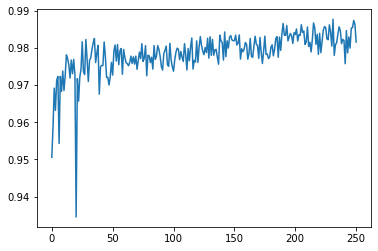

In [62]:
plt.plot(all_auc)

In [ ]:
all_auc

In [63]:
all_auc = np.array(all_auc)

In [64]:
best_auc = all_auc[all_auc>0.98]

In [67]:
a = np.max(best_auc)

In [68]:
a

0.9877646043829019

In [43]:
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:34<00:00,  5.13it/s]


[1 1 1 ... 1 1 0]
tensor([1, 1, 1,  ..., 1, 1, 1])
0.9869065288350394
              precision    recall  f1-score   support

           0     0.9933    0.9744    0.9838     15000
           1     0.9977    0.9994    0.9986    166967

    accuracy                         0.9974    181967
   macro avg     0.9955    0.9869    0.9912    181967
weighted avg     0.9973    0.9974    0.9973    181967

[[ 14616    384]
 [    98 166869]]


In [33]:
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:36<00:00,  4.89it/s]


[1 1 1 ... 1 1 1]
tensor([1, 1, 1,  ..., 1, 1, 1])
0.9810049580655659
              precision    recall  f1-score   support

           0     0.9963    0.9623    0.9790     15000
           1     0.9966    0.9997    0.9981    166967

    accuracy                         0.9966    181967
   macro avg     0.9964    0.9810    0.9886    181967
weighted avg     0.9966    0.9966    0.9966    181967

[[ 14435    565]
 [    54 166913]]


In [ ]:
roc_auc_score()

In [ ]:
test(test)

In [ ]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)
test_y = test_data.y.numpy()
get_metrics(test_y, y_hat)

In [ ]:
get_metrics(test_y, y_hat)

In [181]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.915902  0.964933  0.939779   15000.000000
1              0.999844  0.999167  0.999505   38408.000000
2              0.999684  0.996914  0.998297   47641.000000
3              0.813486  0.965928  0.883178     587.000000
4              1.000000  0.545455  0.705882      11.000000
5              0.992475  0.997479  0.994971    2380.000000
6              0.900365  0.975692  0.936517    1769.000000
7              0.996530  0.990799  0.993656    1739.000000
8              0.988547  0.993939  0.991236    1650.000000
9              0.996787  0.984255  0.990481   69037.000000
10             0.995770  0.990933  0.993345    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.645265  0.889381  0.747907     452.000000
13             0.000000  0.000000  0.000000     196.000000
14             0.333333  0.166667  0.222222       6.000000
accuracy       0.988069  0.988069  0.988069       0.9880

In [59]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.980109  0.946067  0.962787   15000.000000
1              0.999505  0.998203  0.998854   38408.000000
2              0.999580  0.999349  0.999465   47641.000000
3              0.832326  0.938671  0.882306     587.000000
4              1.000000  0.272727  0.428571      11.000000
5              0.989962  0.994538  0.992245    2380.000000
6              0.835676  0.974562  0.899791    1769.000000
7              0.989595  0.984474  0.987028    1739.000000
8              0.984876  0.986667  0.985771    1650.000000
9              0.994949  0.998638  0.996790   69037.000000
10             0.988993  0.989313  0.989153    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.618271  0.838496  0.711737     452.000000
13             0.000000  0.000000  0.000000     196.000000
14             0.000000  0.000000  0.000000       6.000000
accuracy       0.991966  0.991966  0.991966       0.9919

In [130]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)
test_y = test_data.y.numpy()

In [131]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.985699  0.923600  0.953640   15000.000000
1              0.993581  0.999427  0.996495   38408.000000
2              0.996337  0.999055  0.997694   47641.000000
3              0.951220  0.597956  0.734310     587.000000
4              1.000000  0.272727  0.428571      11.000000
5              0.990826  0.998319  0.994558    2380.000000
6              0.814745  0.974562  0.887516    1769.000000
7              0.978482  0.993675  0.986020    1739.000000
8              0.979580  0.988485  0.984012    1650.000000
9              0.994566  0.999479  0.997016   69037.000000
10             0.939356  0.983161  0.960759    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.620870  0.789823  0.695229     452.000000
13             0.000000  0.000000  0.000000     196.000000
14             0.000000  0.000000  0.000000       6.000000
accuracy       0.989443  0.989443  0.989443       0.9894

In [112]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.988604  0.936933  0.962076   15000.000000
1              0.999844  0.998750  0.999297   38408.000000
2              0.999475  0.999202  0.999339   47641.000000
3              0.705497  0.918228  0.797927     587.000000
4              0.000000  0.000000  0.000000      11.000000
5              0.992057  0.997059  0.994552    2380.000000
6              0.814085  0.980215  0.889459    1769.000000
7              0.993048  0.985624  0.989322    1739.000000
8              0.987915  0.990909  0.989410    1650.000000
9              0.994941  0.999928  0.997428   69037.000000
10             0.991262  0.991904  0.991583    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.636215  0.862832  0.732394     452.000000
13             1.000000  0.005102  0.010152     196.000000
14             0.000000  0.000000  0.000000       6.000000
accuracy       0.991944  0.991944  0.991944       0.9919

In [69]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.930174  0.978667  0.953804   15000.000000
1              0.998074  0.993400  0.995732  166967.000000
accuracy       0.992185  0.992185  0.992185       0.992185
macro avg      0.964124  0.986033  0.974768  181967.000000
weighted avg   0.992477  0.992185  0.992275  181967.000000
[[ 14680    320]
 [  1102 165865]]


In [52]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.994470  0.959133  0.976482   15000.000000
1              0.996340  0.999521  0.997928  166967.000000
accuracy       0.996192  0.996192  0.996192       0.996192
macro avg      0.995405  0.979327  0.987205  181967.000000
weighted avg   0.996186  0.996192  0.996160  181967.000000
[[ 14387    613]
 [    80 166887]]


In [53]:
roc_auc_score(test_y, y_hat)

0.9793270983687394

In [38]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.992109  0.963867  0.977784   15000.000000
1              0.996762  0.999311  0.998035  166967.000000
accuracy       0.996389  0.996389  0.996389       0.996389
macro avg      0.994435  0.981589  0.987909  181967.000000
weighted avg   0.996379  0.996389  0.996366  181967.000000
[[ 14458    542]
 [   115 166852]]


In [33]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.994680  0.959733  0.976894   15000.000000
1              0.996394  0.999539  0.997964  166967.000000
accuracy       0.996258  0.996258  0.996258       0.996258
macro avg      0.995537  0.979636  0.987429  181967.000000
weighted avg   0.996253  0.996258  0.996227  181967.000000
[[ 14396    604]
 [    77 166890]]


In [39]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.995477  0.968467  0.981786   15000.000000
1              0.999844  0.999714  0.999779   38408.000000
2              0.999727  0.999244  0.999486   47641.000000
3              0.790123  0.981261  0.875380     587.000000
4              0.750000  0.545455  0.631579      11.000000
5              0.998739  0.998319  0.998529    2380.000000
6              0.953476  0.984737  0.968854    1769.000000
7              0.989649  0.989649  0.989649    1739.000000
8              0.988533  0.992727  0.990626    1650.000000
9              0.996521  0.999928  0.998221   69037.000000
10             0.995779  0.993199  0.994488    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.654264  0.933628  0.769371     452.000000
13             0.500000  0.025510  0.048544     196.000000
14             1.000000  0.500000  0.666667       6.000000
accuracy       0.995345  0.995345  0.995345       0.9953

In [166]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.994277  0.961400  0.977562   15000.000000
1              0.999375  0.999662  0.999518   38408.000000
2              0.999790  0.999391  0.999591   47641.000000
3              0.787380  0.977853  0.872340     587.000000
4              1.000000  0.545455  0.705882      11.000000
5              0.997050  0.994118  0.995582    2380.000000
6              0.914871  0.984172  0.948257    1769.000000
7              0.989679  0.992524  0.991100    1739.000000
8              0.991520  0.992121  0.991821    1650.000000
9              0.996147  0.999928  0.998034   69037.000000
10             0.996745  0.991580  0.994156    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.648819  0.911504  0.758050     452.000000
13             0.833333  0.025510  0.049505     196.000000
14             0.000000  0.000000  0.000000       6.000000
accuracy       0.994642  0.994642  0.994642       0.9946

In [143]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.989197  0.964533  0.976710   15000.000000
1              0.999791  0.998542  0.999166   38408.000000
2              0.999769  0.999370  0.999570   47641.000000
3              0.801688  0.971039  0.878274     587.000000
4              0.666667  0.545455  0.600000      11.000000
5              0.996223  0.997479  0.996851    2380.000000
6              0.919431  0.986998  0.952017    1769.000000
7              0.990794  0.990224  0.990509    1739.000000
8              0.990909  0.990909  0.990909    1650.000000
9              0.996505  0.999450  0.997975   69037.000000
10             0.997390  0.989961  0.993662    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.640123  0.924779  0.756561     452.000000
13             1.000000  0.010204  0.020202     196.000000
14             0.600000  0.500000  0.545455       6.000000
accuracy       0.994499  0.994499  0.994499       0.9944

In [222]:
weight = torch.load('unsw_yhat/cic_epoch_muilt_cnn43', map_location='cpu')

In [224]:
model.load_state_dict(weight)

<All keys matched successfully>

In [36]:
inferrence(model, subgraph_loader)

100%|██████████| 172/172 [00:02<00:00, 84.19it/s]


[0 1 9 ... 0 9 9]
tensor([2, 1, 9,  ..., 2, 9, 9])
              precision    recall  f1-score   support

           0     0.2723    0.9502    0.4233      9000
           1     0.9996    0.9993    0.9995     38408
           2     0.9998    0.5220    0.6859     47641
           3     0.8529    0.9676    0.9066       587
           4     0.6667    0.5455    0.6000        11
           5     0.9975    0.9937    0.9956      2380
           6     0.9148    0.9830    0.9477      1769
           7     0.9936    0.9816    0.9876      1739
           8     0.9774    0.9958    0.9865      1650
           9     0.9972    0.9998    0.9985     69037
          10     0.9877    0.9916    0.9897      3088
          11     0.0000    0.0000    0.0000         3
          12     0.6515    0.8894    0.7521       452
          13     0.7000    0.0357    0.0680       196
          14     0.0000    0.0000    0.0000         6

    accuracy                         0.8656    175967
   macro avg     0.7341    0.

In [209]:
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:53<00:00,  3.32it/s]


[2 1 1 ... 9 1 2]
tensor([2, 1, 1,  ..., 9, 1, 2])
              precision    recall  f1-score   support

           0     0.9940    0.9641    0.9788     15000
           1     0.9996    0.9997    0.9996     38408
           2     0.9991    0.9993    0.9992     47641
           3     0.8457    0.9523    0.8958       587
           4     1.0000    0.5455    0.7059        11
           5     0.9929    0.9983    0.9956      2380
           6     0.9178    0.9842    0.9498      1769
           7     0.9948    0.9919    0.9934      1739
           8     0.9897    0.9933    0.9915      1650
           9     0.9965    0.9999    0.9982     69037
          10     0.9974    0.9926    0.9950      3088
          11     1.0000    1.0000    1.0000         3
          12     0.6446    0.9270    0.7604       452
          13     0.8000    0.0204    0.0398       196
          14     1.0000    0.5000    0.6667         6

    accuracy                         0.9949    181967
   macro avg     0.9448    0.

In [203]:
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:50<00:00,  3.53it/s]


[2 1 1 ... 9 1 2]
tensor([2, 1, 1,  ..., 9, 1, 2])
              precision    recall  f1-score   support

           0     0.9933    0.9641    0.9784     15000
           1     0.9995    0.9997    0.9996     38408
           2     0.9994    0.9993    0.9994     47641
           3     0.8560    0.9319    0.8923       587
           4     0.8571    0.5455    0.6667        11
           5     0.9966    0.9971    0.9968      2380
           6     0.9158    0.9836    0.9485      1769
           7     0.9948    0.9925    0.9937      1739
           8     0.9927    0.9921    0.9924      1650
           9     0.9961    0.9999    0.9980     69037
          10     0.9948    0.9929    0.9938      3088
          11     1.0000    1.0000    1.0000         3
          12     0.6426    0.9270    0.7591       452
          13     0.7500    0.0306    0.0588       196
          14     1.0000    0.1667    0.2857         6

    accuracy                         0.9948    181967
   macro avg     0.9326    0.

In [188]:
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:21<00:00,  8.28it/s]


[2 1 1 ... 9 1 2]
tensor([2, 1, 1,  ..., 9, 1, 2])
              precision    recall  f1-score   support

           0     0.9563    0.9538    0.9550     15000
           1     0.9996    0.9993    0.9995     38408
           2     0.9971    0.9993    0.9982     47641
           3     0.7980    0.9625    0.8726       587
           4     0.8571    0.5455    0.6667        11
           5     0.9924    0.9941    0.9933      2380
           6     0.9172    0.9768    0.9461      1769
           7     0.9868    0.9925    0.9897      1739
           8     0.9933    0.9933    0.9933      1650
           9     0.9960    0.9999    0.9979     69037
          10     0.9948    0.9903    0.9925      3088
          11     1.0000    1.0000    1.0000         3
          12     0.6867    0.1261    0.2131       452
          13     0.5000    0.0051    0.0101       196
          14     0.6000    0.5000    0.5455         6

    accuracy                         0.9918    181967
   macro avg     0.8850    0.

In [184]:
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:23<00:00,  7.57it/s]


[2 1 1 ... 9 1 2]
tensor([2, 1, 1,  ..., 9, 1, 2])
              precision    recall  f1-score   support

           0     0.9925    0.9610    0.9765     15000
           1     0.9997    0.9994    0.9996     38408
           2     0.9995    0.9994    0.9994     47641
           3     0.8286    0.9472    0.8839       587
           4     0.8571    0.5455    0.6667        11
           5     0.9933    0.9975    0.9954      2380
           6     0.9086    0.9836    0.9446      1769
           7     0.9931    0.9902    0.9916      1739
           8     0.9909    0.9933    0.9921      1650
           9     0.9960    0.9999    0.9980     69037
          10     0.9958    0.9919    0.9938      3088
          11     1.0000    1.0000    1.0000         3
          12     0.6330    0.9004    0.7434       452
          13     0.3333    0.0051    0.0101       196
          14     1.0000    0.5000    0.6667         6

    accuracy                         0.9945    181967
   macro avg     0.9014    0.

In [32]:
# cic_epoch_muilt467
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:20<00:00,  8.66it/s]


[2 1 1 ... 9 1 2]
tensor([2, 1, 1,  ..., 9, 1, 2])
              precision    recall  f1-score   support

           0   0.996276  0.963200  0.979459     15000
           1   0.999662  0.999662  0.999662     38408
           2   0.996817  0.999286  0.998050     47641
           3   0.800000  0.981261  0.881408       587
           4   1.000000  0.545455  0.705882        11
           5   0.994981  0.999580  0.997275      2380
           6   0.952589  0.988129  0.970033      1769
           7   0.994795  0.989074  0.991926      1739
           8   0.991541  0.994545  0.993041      1650
           9   0.997226  0.999899  0.998561     69037
          10   0.994797  0.990609  0.992698      3088
          11   1.000000  1.000000  1.000000         3
          12   0.658915  0.940265  0.774840       452
          13   0.545455  0.030612  0.057971       196
          14   0.500000  0.500000  0.500000         6

    accuracy                       0.994939    181967
   macro avg   0.894870  0.86

In [28]:
# cic_epoch_muilt467
inferrence(model, subgraph_loader)

100%|██████████| 178/178 [00:21<00:00,  8.27it/s]


[2 1 1 ... 9 1 2]
tensor([2, 1, 1,  ..., 9, 1, 2])
              precision    recall  f1-score   support

           0     0.9961    0.9631    0.9793     15000
           1     0.9997    0.9997    0.9997     38408
           2     0.9968    0.9993    0.9981     47641
           3     0.7978    0.9813    0.8801       587
           4     1.0000    0.5455    0.7059        11
           5     0.9954    0.9996    0.9975      2380
           6     0.9526    0.9881    0.9700      1769
           7     0.9948    0.9896    0.9922      1739
           8     0.9915    0.9945    0.9930      1650
           9     0.9972    0.9999    0.9986     69037
          10     0.9948    0.9906    0.9927      3088
          11     1.0000    1.0000    1.0000         3
          12     0.6610    0.9403    0.7763       452
          13     0.5000    0.0306    0.0577       196
          14     0.5000    0.5000    0.5000         6

    accuracy                         0.9949    181967
   macro avg     0.8918    0.

In [37]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)
test_y = test_data.y.numpy()
get_metrics(test_y, y_hat) 

In [39]:
# depth=10
get_metrics(test_y, y_hat) 

              precision    recall  f1-score        support
0              0.272025  0.950333  0.422976    9000.000000
1              0.999609  0.998933  0.999271   38408.000000
2              0.999678  0.522008  0.685871   47641.000000
3              0.852853  0.967632  0.906624     587.000000
4              0.666667  0.545455  0.600000      11.000000
5              0.998310  0.992857  0.995576    2380.000000
6              0.914782  0.983041  0.947684    1769.000000
7              0.993593  0.981024  0.987269    1739.000000
8              0.976247  0.996364  0.986203    1650.000000
9              0.997196  0.999536  0.998365   69037.000000
10             0.987726  0.990285  0.989004    3088.000000
11             0.000000  0.000000  0.000000       3.000000
12             0.651540  0.889381  0.752105     452.000000
13             0.700000  0.035714  0.067961     196.000000
14             0.000000  0.000000  0.000000       6.000000
accuracy       0.865429  0.865429  0.865429       0.8654

In [ ]:
# depth=10
get_metrics(test_y, y_hat) 

In [212]:
# depth=10
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.991470  0.945333  0.967852   15000.000000
1              0.995109  0.999269  0.997185  166967.000000
accuracy       0.994823  0.994823  0.994823       0.994823
macro avg      0.993290  0.972301  0.982518  181967.000000
weighted avg   0.994809  0.994823  0.994767  181967.000000
[[ 14180    820]
 [   122 166845]]


In [200]:
# depth=5
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.956051  0.960067  0.958055   15000.00000
1              0.996411  0.996035  0.996223  166967.00000
accuracy       0.993070  0.993070  0.993070       0.99307
macro avg      0.976231  0.978051  0.977139  181967.00000
weighted avg   0.993084  0.993070  0.993077  181967.00000
[[ 14401    599]
 [   662 166305]]


In [194]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.977647  0.953467  0.965406   15000.000000
1              0.995829  0.998042  0.996934  166967.000000
accuracy       0.994367  0.994367  0.994367       0.994367
macro avg      0.986738  0.975754  0.981170  181967.000000
weighted avg   0.994330  0.994367  0.994335  181967.000000
[[ 14302    698]
 [   327 166640]]


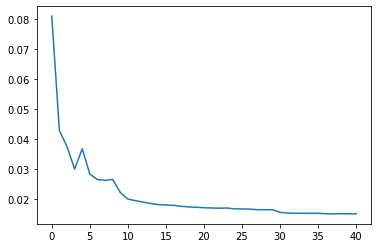

In [175]:
# 多分类loss
plt.plot(loss_all)

In [176]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.987821  0.962467  0.974979   15000.000000
1              0.999635  0.998750  0.999193   38408.000000
2              0.999664  0.999349  0.999507   47641.000000
3              0.820175  0.955707  0.882769     587.000000
4              1.000000  0.545455  0.705882      11.000000
5              0.997476  0.996218  0.996847    2380.000000
6              0.919449  0.980780  0.949125    1769.000000
7              0.992533  0.993675  0.993103    1739.000000
8              0.987930  0.992121  0.990021    1650.000000
9              0.996329  0.998624  0.997475   69037.000000
10             0.982074  0.993523  0.987766    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.635671  0.922566  0.752708     452.000000
13             0.277778  0.025510  0.046729     196.000000
14             1.000000  0.500000  0.666667       6.000000
accuracy       0.994043  0.994043  0.994043       0.9940

In [167]:
Counter(train_data.y.numpy())

Counter({1: 89617,
         2: 111163,
         0: 35000,
         9: 161087,
         7: 4057,
         8: 3849,
         10: 7205,
         3: 1369,
         5: 5555,
         6: 4128,
         12: 1055,
         13: 456,
         14: 15,
         4: 25,
         11: 8})

In [168]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.988160  0.962533  0.975178   15000.000000
1              0.999557  0.998906  0.999232   38408.000000
2              0.999664  0.999349  0.999507   47641.000000
3              0.822157  0.960818  0.886096     587.000000
4              1.000000  0.545455  0.705882      11.000000
5              0.996637  0.996218  0.996428    2380.000000
6              0.919936  0.980780  0.949384    1769.000000
7              0.993096  0.992524  0.992810    1739.000000
8              0.988533  0.992727  0.990626    1650.000000
9              0.996030  0.999261  0.997643   69037.000000
10             0.996402  0.986399  0.991375    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.638591  0.922566  0.754751     452.000000
13             0.277778  0.025510  0.046729     196.000000
14             1.000000  0.500000  0.666667       6.000000
accuracy       0.994213  0.994213  0.994213       0.9942

In [158]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.988764  0.956267  0.972244   15000.000000
1              0.999557  0.998750  0.999153   38408.000000
2              0.999601  0.999349  0.999475   47641.000000
3              0.773585  0.977853  0.863807     587.000000
4              0.857143  0.545455  0.666667      11.000000
5              0.997060  0.997479  0.997269    2380.000000
6              0.911333  0.981911  0.945306    1769.000000
7              0.993076  0.989649  0.991359    1739.000000
8              0.986145  0.992121  0.989124    1650.000000
9              0.995411  0.999218  0.997311   69037.000000
10             0.996401  0.986075  0.991211    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.635258  0.924779  0.753153     452.000000
13             0.750000  0.015306  0.030000     196.000000
14             1.000000  0.500000  0.666667       6.000000
accuracy       0.993686  0.993686  0.993686       0.9936

In [148]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.986405  0.962600  0.974357   15000.000000
1              0.999479  0.998490  0.998984   38408.000000
2              0.999748  0.999328  0.999538   47641.000000
3              0.879227  0.930153  0.903974     587.000000
4              0.833333  0.454545  0.588235      11.000000
5              0.989167  0.997479  0.993305    2380.000000
6              0.904886  0.984172  0.942865    1769.000000
7              0.991959  0.993099  0.992529    1739.000000
8              0.989130  0.992727  0.990926    1650.000000
9              0.995598  0.999145  0.997368   69037.000000
10             0.997052  0.985751  0.991369    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.649533  0.922566  0.762340     452.000000
13             0.800000  0.020408  0.039801     196.000000
14             0.750000  0.500000  0.600000       6.000000
accuracy       0.994015  0.994015  0.994015       0.9940

In [141]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.980783  0.942467  0.961243   15000.000000
1              0.999635  0.997813  0.998723   38408.000000
2              0.994880  0.999286  0.997078   47641.000000
3              0.893836  0.889267  0.891546     587.000000
4              0.800000  0.363636  0.500000      11.000000
5              0.991162  0.989496  0.990328    2380.000000
6              0.871421  0.980780  0.922872    1769.000000
7              0.989087  0.990224  0.989655    1739.000000
8              0.988533  0.992727  0.990626    1650.000000
9              0.994836  0.999030  0.996928   69037.000000
10             0.988053  0.990933  0.989491    3088.000000
11             1.000000  1.000000  1.000000       3.000000
12             0.625000  0.796460  0.700389     452.000000
13             0.000000  0.000000  0.000000     196.000000
14             0.000000  0.000000  0.000000       6.000000
accuracy       0.991592  0.991592  0.991592       0.9915

In [129]:
get_metrics(y_true, y_pred)

              precision    recall  f1-score       support
0              0.976466  0.986593  0.981503  13500.000000
1              0.999332  0.997333  0.998332   3000.000000
2              0.999000  0.999333  0.999167   3000.000000
3              0.895455  0.672355  0.768031    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.997479  0.997479  0.997479   1190.000000
6              0.904124  0.990960  0.945553    885.000000
7              0.991851  0.979310  0.985541    870.000000
8              0.977300  0.991515  0.984356    825.000000
9              0.985639  0.938000  0.961230   3000.000000
10             0.993532  0.994819  0.994175   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.637224  0.893805  0.744015    226.000000
13             0.857143  0.061224  0.114286     98.000000
14             1.000000  0.333333  0.500000      3.000000
accuracy       0.977568  0.977568  0.977568      0.977568
macro avg     

In [89]:
get_metrics(y_true, y_pred)

              precision    recall  f1-score       support
0              0.992785  0.978519  0.985600  13500.000000
1              0.998665  0.997667  0.998166   3000.000000
2              0.998004  1.000000  0.999001   3000.000000
3              0.815534  0.860068  0.837209    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.996644  0.998319  0.997481   1190.000000
6              0.911366  0.987571  0.947939    885.000000
7              0.991889  0.983908  0.987882    870.000000
8              0.976105  0.990303  0.983153    825.000000
9              0.964401  0.993333  0.978654   3000.000000
10             0.994186  0.996762  0.995472   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.641509  0.902655  0.750000    226.000000
13             0.800000  0.081633  0.148148     98.000000
14             1.000000  0.666667  0.800000      3.000000
accuracy       0.981927  0.981927  0.981927      0.981927
macro avg     

In [78]:
get_metrics(y_true, y_pred)

              precision    recall  f1-score       support
0              0.991599  0.979259  0.985391  13500.000000
1              0.998665  0.997667  0.998166   3000.000000
2              0.998336  1.000000  0.999167   3000.000000
3              0.834459  0.843003  0.838710    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.996644  0.998319  0.997481   1190.000000
6              0.912134  0.985311  0.947311    885.000000
7              0.991889  0.983908  0.987882    870.000000
8              0.976134  0.991515  0.983764    825.000000
9              0.964286  0.990000  0.976974   3000.000000
10             0.994186  0.996762  0.995472   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.642633  0.907080  0.752294    226.000000
13             0.888889  0.081633  0.149533     98.000000
14             1.000000  0.666667  0.800000      3.000000
accuracy       0.981752  0.981752  0.981752      0.981752
macro avg     

In [77]:
get_metrics(y_true, y_pred)

              precision    recall  f1-score       support
0              0.991599  0.979259  0.985391  13500.000000
1              0.998665  0.997667  0.998166   3000.000000
2              0.998336  1.000000  0.999167   3000.000000
3              0.834459  0.843003  0.838710    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.996644  0.998319  0.997481   1190.000000
6              0.912134  0.985311  0.947311    885.000000
7              0.991889  0.983908  0.987882    870.000000
8              0.976134  0.991515  0.983764    825.000000
9              0.964286  0.990000  0.976974   3000.000000
10             0.994186  0.996762  0.995472   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.642633  0.907080  0.752294    226.000000
13             0.888889  0.081633  0.149533     98.000000
14             1.000000  0.666667  0.800000      3.000000
accuracy       0.981752  0.981752  0.981752      0.981752
macro avg     

In [66]:
get_metrics(y_true, y_pred)

              precision    recall  f1-score       support
0              0.990563  0.979630  0.985066  13500.000000
1              0.998998  0.997333  0.998165   3000.000000
2              0.998336  1.000000  0.999167   3000.000000
3              0.830565  0.853242  0.841751    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.997479  0.997479  0.997479   1190.000000
6              0.918085  0.975141  0.945753    885.000000
7              0.990741  0.983908  0.987313    870.000000
8              0.976134  0.991515  0.983764    825.000000
9              0.964821  0.987333  0.975947   3000.000000
10             0.993544  0.996762  0.995150   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.636923  0.915929  0.751361    226.000000
13             0.875000  0.071429  0.132075     98.000000
14             1.000000  0.333333  0.500000      3.000000
accuracy       0.981365  0.981365  0.981365      0.981365
macro avg     

In [57]:
get_metrics(y_true, y_pred)

              precision    recall  f1-score       support
0              0.981721  0.982667  0.982194  13500.000000
1              0.998331  0.997000  0.997665   3000.000000
2              0.998336  0.999667  0.999001   3000.000000
3              0.806061  0.907850  0.853933    293.000000
4              0.666667  0.400000  0.500000      5.000000
5              0.996641  0.997479  0.997060   1190.000000
6              0.904911  0.978531  0.940282    885.000000
7              0.988426  0.981609  0.985006    870.000000
8              0.979616  0.990303  0.984931    825.000000
9              0.983994  0.942667  0.962887   3000.000000
10             0.992253  0.995466  0.993857   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.641270  0.893805  0.746765    226.000000
13             1.000000  0.081633  0.150943     98.000000
14             1.000000  0.333333  0.500000      3.000000
accuracy       0.978376  0.978376  0.978376      0.978376
macro avg     

In [74]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.975621  0.972296  0.973956  13500.000000
1              0.998666  0.998333  0.998500   3000.000000
2              0.996343  0.999000  0.997670   3000.000000
3              0.829787  0.931741  0.877814    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.995816  1.000000  0.997904   1190.000000
6              0.869522  0.986441  0.924299    885.000000
7              0.989595  0.983908  0.986744    870.000000
8              0.978520  0.993939  0.986170    825.000000
9              0.949921  0.999000  0.973842   3000.000000
10             0.992903  0.996762  0.994829   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.783784  0.128319  0.220532    226.000000
13             0.000000  0.000000  0.000000     98.000000
14             1.000000  0.666667  0.800000      3.000000
accuracy       0.973981  0.973981  0.973981      0.973981
macro avg     

In [36]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score     support
0              0.988125  0.967704  0.977808  13500.0000
1              0.994684  0.998000  0.996339   3000.0000
2              0.991722  0.998333  0.995017   3000.0000
3              0.932384  0.894198  0.912892    293.0000
4              0.000000  0.000000  0.000000      5.0000
5              0.998309  0.992437  0.995365   1190.0000
6              0.844206  0.979661  0.906904    885.0000
7              0.978111  0.975862  0.976985    870.0000
8              0.974850  0.986667  0.980723    825.0000
9              0.940102  0.978333  0.958837   3000.0000
10             0.992263  0.996762  0.994507   1544.0000
11             1.000000  1.000000  1.000000      2.0000
12             0.593750  0.840708  0.695971    226.0000
13             0.000000  0.000000  0.000000     98.0000
14             1.000000  0.333333  0.500000      3.0000
accuracy       0.973700  0.973700  0.973700      0.9737
macro avg      0.815234  0.796133  0.792756  284

In [32]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.970778  0.967111  0.968941  13500.000000
1              0.999665  0.996000  0.997829   3000.000000
2              0.947468  0.998000  0.972078   3000.000000
3              0.906897  0.897611  0.902230    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.992431  0.991597  0.992013   1190.000000
6              0.846530  0.978531  0.907757    885.000000
7              0.971231  0.970115  0.970673    870.000000
8              0.967819  0.984242  0.975962    825.000000
9              0.979592  0.912000  0.944588   3000.000000
10             0.996073  0.985751  0.990885   1544.000000
11             1.000000  0.500000  0.666667      2.000000
12             0.608414  0.831858  0.702804    226.000000
13             0.000000  0.000000  0.000000     98.000000
14             0.000000  0.000000  0.000000      3.000000
accuracy       0.965226  0.965226  0.965226      0.965226
macro avg     

In [66]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.877884  0.947500  0.911364   10000.000000
1              0.995250  0.988159  0.991692  111312.000000
accuracy       0.984808  0.984808  0.984808       0.984808
macro avg      0.936567  0.967830  0.951528  121312.000000
weighted avg   0.985575  0.984808  0.985070  121312.000000
[[  9475    525]
 [  1318 109994]]


In [60]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.988858  0.958500  0.973442   10000.000000
1              0.996282  0.999030  0.997654  111312.000000
accuracy       0.995689  0.995689  0.995689       0.995689
macro avg      0.992570  0.978765  0.985548  121312.000000
weighted avg   0.995670  0.995689  0.995658  121312.000000
[[  9585    415]
 [   108 111204]]


In [53]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.994276  0.955400  0.974451   10000.00000
1              0.996007  0.999506  0.997754  111312.00000
accuracy       0.995870  0.995870  0.995870       0.99587
macro avg      0.995142  0.977453  0.986102  121312.00000
weighted avg   0.995865  0.995870  0.995833  121312.00000
[[  9554    446]
 [    55 111257]]


In [67]:
roc_auc_score(test_y, y_hat)

0.9678297038953573

In [46]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.987040  0.913900  0.949063   10000.000000
1              0.992316  0.998922  0.995608  111312.000000
accuracy       0.991913  0.991913  0.991913       0.991913
macro avg      0.989678  0.956411  0.972335  121312.000000
weighted avg   0.991881  0.991913  0.991771  121312.000000
[[  9139    861]
 [   120 111192]]


In [54]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.991007  0.958700  0.974586   10000.000000
1              0.996301  0.999218  0.997757  111312.000000
accuracy       0.995878  0.995878  0.995878       0.995878
macro avg      0.993654  0.978959  0.986172  121312.000000
weighted avg   0.995864  0.995878  0.995847  121312.000000
[[  9587    413]
 [    87 111225]]


In [48]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.991011  0.959200  0.974846   10000.00000
1              0.996345  0.999218  0.997780  111312.00000
accuracy       0.995920  0.995920  0.995920       0.99592
macro avg      0.993678  0.979209  0.986313  121312.00000
weighted avg   0.995905  0.995920  0.995889  121312.00000
[[  9592    408]
 [    87 111225]]


In [41]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.994256  0.952100  0.972722   10000.000000
1              0.995713  0.999506  0.997606  111312.000000
accuracy       0.995598  0.995598  0.995598       0.995598
macro avg      0.994985  0.975803  0.985164  121312.000000
weighted avg   0.995593  0.995598  0.995555  121312.000000
[[  9521    479]
 [    55 111257]]


In [35]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.993787  0.943700  0.968096   10000.000000
1              0.994965  0.999470  0.997212  111312.000000
accuracy       0.994873  0.994873  0.994873       0.994873
macro avg      0.994376  0.971585  0.982654  121312.000000
weighted avg   0.994868  0.994873  0.994812  121312.000000
[[  9437    563]
 [    59 111253]]


In [28]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.960407  0.839300  0.895779   10000.000000
1              0.985725  0.996892  0.991277  111312.000000
accuracy       0.983901  0.983901  0.983901       0.983901
macro avg      0.973066  0.918096  0.943528  121312.000000
weighted avg   0.983638  0.983901  0.983405  121312.000000
[[  8393   1607]
 [   346 110966]]


In [45]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.985363  0.949200  0.966943   10000.000000
1              0.996612  0.999276  0.997942   75950.000000
2              0.996108  0.999213  0.997658   31761.000000
3              0.980170  0.884910  0.930108     391.000000
4              1.000000  0.571429  0.727273       7.000000
5              0.952331  0.989158  0.970395    2767.000000
6              0.894253  0.892202  0.893226     436.000000
accuracy       0.994123  0.994123  0.994123       0.994123
macro avg      0.972120  0.897913  0.926221  121312.000000
weighted avg   0.994122  0.994123  0.994074  121312.000000
[[ 9492   216   124     7     0   120    41]
 [   51 75895     0     0     0     2     2]
 [    4    18 31736     0     0     0     3]
 [   45     0     0   346     0     0     0]
 [    1     1     0     0     4     1     0]
 [   14    16     0     0     0  2737     0]
 [   26     7     0     0     0    14   389]]


In [32]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.980632  0.936700  0.958163   10000.000000
1              0.996335  0.998591  0.997462   75950.000000
2              0.995858  0.999213  0.997533   31761.000000
3              0.783505  0.971867  0.867580     391.000000
4              1.000000  0.142857  0.250000       7.000000
5              0.944967  0.980484  0.962398    2767.000000
6              0.912833  0.864679  0.888104     436.000000
accuracy       0.992622  0.992622  0.992622       0.992622
macro avg      0.944876  0.842056  0.845891  121312.000000
weighted avg   0.992758  0.992622  0.992586  121312.000000
[[ 9367   237   131   105     0   127    33]
 [  102 75843     1     0     0     2     2]
 [    6    18 31736     0     0     0     1]
 [   11     0     0   380     0     0     0]
 [    6     0     0     0     1     0     0]
 [   37    17     0     0     0  2713     0]
 [   23     7     0     0     0    29   377]]


In [59]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.934755  0.964200  0.949249   10000.000000
1              0.998133  0.999776  0.998954   75950.000000
2              0.996702  0.999244  0.997972   31761.000000
3              0.843602  0.910486  0.875769     391.000000
4              0.833333  0.714286  0.769231       7.000000
5              0.977477  0.784243  0.870263    2767.000000
6              0.935185  0.926606  0.930876     436.000000
accuracy       0.991221  0.991221  0.991221       0.991221
macro avg      0.931313  0.899834  0.913188  121312.000000
weighted avg   0.991329  0.991221  0.991009  121312.000000
[[ 9642   113   104    66     1    50    24]
 [   15 75933     0     0     0     0     2]
 [    2    20 31737     0     0     0     2]
 [   34     1     0   356     0     0     0]
 [    1     1     0     0     5     0     0]
 [  595     2     0     0     0  2170     0]
 [   26     5     1     0     0     0   404]]


In [43]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.991888  0.941500  0.966037   10000.000000
1              0.994768  0.999308  0.997033  111312.000000
accuracy       0.994543  0.994543  0.994543       0.994543
macro avg      0.993328  0.970404  0.981535  121312.000000
weighted avg   0.994531  0.994543  0.994478  121312.000000
[[  9415    585]
 [    77 111235]]


In [34]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.991231  0.915600  0.951916   10000.000000
1              0.992469  0.999272  0.995859  111312.000000
accuracy       0.992375  0.992375  0.992375       0.992375
macro avg      0.991850  0.957436  0.973887  121312.000000
weighted avg   0.992367  0.992375  0.992237  121312.000000
[[  9156    844]
 [    81 111231]]


In [58]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.983025  0.949733  0.966092   7500.000000
1              0.988113  0.989610  0.988861   9240.000000
2              0.963047  0.990333  0.976500   3000.000000
3              0.821429  0.938776  0.876190    294.000000
4              1.000000  0.600000  0.750000      5.000000
5              0.946379  0.995181  0.970167   2075.000000
6              0.913433  0.935780  0.924471    327.000000
accuracy       0.975358  0.975358  0.975358      0.975358
macro avg      0.945061  0.914202  0.921755  22441.000000
weighted avg   0.975934  0.975358  0.975403  22441.000000
[[7123  100  106   60    0   88   23]
 [  92 9144    0    0    0    3    1]
 [   3    6 2971    0    0   15    5]
 [  17    0    1  276    0    0    0]
 [   1    1    0    0    3    0    0]
 [   3    1    6    0    0 2065    0]
 [   7    2    1    0    0   11  306]]


In [52]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.983317  0.950933  0.966854   7500.000000
1              0.989527  0.991883  0.990704   9240.000000
2              0.963324  0.989333  0.976155   3000.000000
3              0.808140  0.945578  0.871473    294.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.945747  0.991325  0.968000   2075.000000
6              0.929012  0.920489  0.924731    327.000000
accuracy       0.976026  0.976026  0.976026      0.976026
macro avg      0.945581  0.884220  0.895621  22441.000000
weighted avg   0.976645  0.976026  0.976072  22441.000000
[[7132   87  107   66    0   87   21]
 [  73 9165    0    0    0    1    1]
 [   6    6 2968    0    0   19    1]
 [  15    0    1  278    0    0    0]
 [   2    1    0    0    2    0    0]
 [  12    1    5    0    0 2057    0]
 [  13    2    0    0    0   11  301]]


In [30]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.979393  0.937867  0.958180   7500.000000
1              0.984289  0.989935  0.987104   9240.000000
2              0.965260  0.991000  0.977961   3000.000000
3              0.695444  0.986395  0.815752    294.000000
4              1.000000  0.600000  0.750000      5.000000
5              0.957249  0.992771  0.974687   2075.000000
6              0.929936  0.892966  0.911076    327.000000
accuracy       0.971392  0.971392  0.971392      0.971392
macro avg      0.930224  0.912991  0.910680  22441.000000
weighted avg   0.973036  0.971392  0.971661  22441.000000
[[7034  135  106  127    0   78   20]
 [  89 9147    0    0    0    3    1]
 [  21    5 2973    0    0    0    1]
 [   4    0    0  290    0    0    0]
 [   2    0    0    0    3    0    0]
 [  10    4    1    0    0 2060    0]
 [  22    2    0    0    0   11  292]]


In [281]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.986649  0.968889  0.977688  13500.000000
1              0.980925  0.996104  0.988456   9241.000000
2              0.997008  0.999667  0.998336   3000.000000
3              0.671698  0.607509  0.637993    293.000000
4              1.000000  0.600000  0.750000      5.000000
5              0.941632  0.995181  0.967666   2075.000000
6              0.894260  0.905199  0.899696    327.000000
accuracy       0.978376  0.978376  0.978376      0.978376
macro avg      0.924596  0.867507  0.888548  28441.000000
weighted avg   0.978293  0.978376  0.978197  28441.000000
[[13080   174     9    87     0   115    35]
 [   35  9205     0     0     0     1     0]
 [    1     0  2999     0     0     0     0]
 [  115     0     0   178     0     0     0]
 [    2     0     0     0     3     0     0]
 [    8     2     0     0     0  2065     0]
 [   16     3     0     0     0    12   296]]


In [275]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.994143  0.968148  0.980973  13500.000000
1              0.980196  0.996213  0.988139   9241.000000
2              0.996678  1.000000  0.998336   3000.000000
3              0.768156  0.938567  0.844854    293.000000
4              1.000000  0.600000  0.750000      5.000000
5              0.938636  0.995181  0.966082   2075.000000
6              0.894260  0.905199  0.899696    327.000000
accuracy       0.981506  0.981506  0.981506      0.981506
macro avg      0.938867  0.914758  0.918297  28441.000000
weighted avg   0.982354  0.981506  0.981669  28441.000000
[[13070   180    10    83     0   122    35]
 [   34  9206     0     0     0     1     0]
 [    0     0  3000     0     0     0     0]
 [   18     0     0   275     0     0     0]
 [    2     0     0     0     3     0     0]
 [    7     3     0     0     0  2065     0]
 [   16     3     0     0     0    12   296]]


In [266]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.993883  0.962815  0.978102  13500.000000
1              0.980198  0.996321  0.988194   9241.000000
2              0.996347  1.000000  0.998170   3000.000000
3              0.638009  0.962457  0.767347    293.000000
4              1.000000  0.600000  0.750000      5.000000
5              0.940585  0.991807  0.965517   2075.000000
6              0.898773  0.896024  0.897397    327.000000
accuracy       0.978904  0.978904  0.978904      0.978904
macro avg      0.921114  0.915632  0.906390  28441.000000
weighted avg   0.981049  0.978904  0.979440  28441.000000
[[12998   181    11   160     0   117    33]
 [   33  9207     0     0     0     1     0]
 [    0     0  3000     0     0     0     0]
 [   11     0     0   282     0     0     0]
 [    2     0     0     0     3     0     0]
 [   15     2     0     0     0  2058     0]
 [   19     3     0     0     0    12   293]]


In [260]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.989948  0.962963  0.976269  13500.000000
1              0.979464  0.996104  0.987714   9241.000000
2              0.996016  1.000000  0.998004   3000.000000
3              0.601064  0.771331  0.675635    293.000000
4              1.000000  0.600000  0.750000      5.000000
5              0.941042  0.992289  0.965986   2075.000000
6              0.885542  0.899083  0.892261    327.000000
accuracy       0.977005  0.977005  0.977005      0.977005
macro avg      0.913297  0.888824  0.892267  28441.000000
weighted avg   0.978409  0.977005  0.977427  28441.000000
[[13000   185    12   150     0   116    37]
 [   34  9205     0     0     0     1     1]
 [    0     0  3000     0     0     0     0]
 [   67     0     0   226     0     0     0]
 [    2     0     0     0     3     0     0]
 [   14     2     0     0     0  2059     0]
 [   15     6     0     0     0    12   294]]


In [254]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.989918  0.967333  0.978495  13500.000000
1              0.979653  0.989936  0.984768   9241.000000
2              0.996678  1.000000  0.998336   3000.000000
3              0.785311  0.948805  0.859351    293.000000
4              1.000000  0.600000  0.750000      5.000000
5              0.925694  0.996627  0.959851   2075.000000
6              0.906452  0.859327  0.882261    327.000000
accuracy       0.978763  0.978763  0.978763      0.978763
macro avg      0.940529  0.908861  0.916152  28441.000000
weighted avg   0.979544  0.978763  0.978892  28441.000000
[[13059   182    10    76     0   144    29]
 [   92  9148     0     0     0     1     0]
 [    0     0  3000     0     0     0     0]
 [   15     0     0   278     0     0     0]
 [    2     0     0     0     3     0     0]
 [    4     3     0     0     0  2068     0]
 [   20     5     0     0     0    21   281]]


In [238]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.992030  0.968148  0.979944  13500.000000
1              0.975294  0.995347  0.985219   9241.000000
2              0.994360  0.999000  0.996674   3000.000000
3              0.910072  0.863481  0.886165    293.000000
4              1.000000  0.400000  0.571429      5.000000
5              0.931736  0.993253  0.961512   2075.000000
6              0.875380  0.880734  0.878049    327.000000
accuracy       0.979888  0.979888  0.979888      0.979888
macro avg      0.954125  0.871423  0.894141  28441.000000
weighted avg   0.980255  0.979888  0.979868  28441.000000
[[13070   218    17    25     0   130    40]
 [   41  9198     0     0     0     1     1]
 [    1     2  2997     0     0     0     0]
 [   40     0     0   253     0     0     0]
 [    3     0     0     0     2     0     0]
 [    8     6     0     0     0  2061     0]
 [   12     7     0     0     0    20   288]]


In [198]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(test_y, y_hat)
print(df)
print(cm)

              precision    recall  f1-score      support
0              0.993439  0.964519  0.978765  13500.00000
1              0.998663  0.996000  0.997330   3000.00000
2              0.993371  0.999000  0.996177   3000.00000
3              0.733871  0.931741  0.821053    293.00000
4              1.000000  0.600000  0.750000      5.00000
5              0.986722  0.999160  0.992902   1190.00000
6              0.871821  0.968362  0.917559    885.00000
7              0.989535  0.978161  0.983815    870.00000
8              0.978443  0.990303  0.984337    825.00000
9              0.936110  0.996333  0.965283   3000.00000
10             0.990956  0.993523  0.992238   1544.00000
11             1.000000  1.000000  1.000000      2.00000
12             0.632911  0.884956  0.738007    226.00000
13             1.000000  0.020408  0.040000     98.00000
14             0.166667  0.333333  0.222222      3.00000
accuracy       0.974790  0.974790  0.974790      0.97479
macro avg      0.884834  0.8437

In [137]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(test_y, y_hat)
print(df)
print(cm)

              precision    recall  f1-score       support
0              0.993320  0.958222  0.975455  13500.000000
1              0.997996  0.996000  0.996997   3000.000000
2              0.948767  1.000000  0.973710   3000.000000
3              0.959559  0.890785  0.923894    293.000000
4              0.250000  0.400000  0.307692      5.000000
5              0.988285  0.992437  0.990356   1190.000000
6              0.863410  0.978531  0.917373    885.000000
7              0.980437  0.979310  0.979873    870.000000
8              0.979665  0.992727  0.986153    825.000000
9              0.938539  0.997667  0.967200   3000.000000
10             0.983974  0.994171  0.989046   1544.000000
11             1.000000  1.000000  1.000000      2.000000
12             0.636364  0.898230  0.744954    226.000000
13             0.875000  0.071429  0.132075     98.000000
14             1.000000  0.333333  0.500000      3.000000
accuracy       0.972047  0.972047  0.972047      0.972047
macro avg     

In [73]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(test_y, y_hat)
print(df)
print(cm)

              precision    recall  f1-score       support
0              0.993732  0.962963  0.978105  13500.000000
1              0.967446  0.994512  0.980792  14941.000000
accuracy       0.979537  0.979537  0.979537      0.979537
macro avg      0.980589  0.978737  0.979449  28441.000000
weighted avg   0.979923  0.979537  0.979517  28441.000000
[[13000   500]
 [   82 14859]]


In [57]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(test_y, y_hat)
print(df)
print(cm)

              precision    recall  f1-score       support
0              0.995864  0.963185  0.979252  13500.000000
1              0.967694  0.996386  0.981830  14941.000000
accuracy       0.980627  0.980627  0.980627      0.980627
macro avg      0.981779  0.979785  0.980541  28441.000000
weighted avg   0.981065  0.980627  0.980606  28441.000000
[[13003   497]
 [   54 14887]]


In [48]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
cm = confusion_matrix(test_y, y_hat)
print(cr)
print(cm)

,precision,recall,f1-score,support
0,0.995899,0.953407,0.974190,13500.000000
1,0.959464,0.996453,0.977609,14941.000000
accuracy,0.976021,0.976021,0.976021,0.976021
macro avg,0.977681,0.974930,0.975899,28441.000000
weighted avg,0.976758,0.976021,0.975986,28441.000000


In [30]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.993712,0.959926,0.976527,13500.000000
1,0.964870,0.994512,0.979467,14941.000000
accuracy,0.978095,0.978095,0.978095,0.978095
macro avg,0.979291,0.977219,0.977997,28441.000000
weighted avg,0.978560,0.978095,0.978071,28441.000000


In [78]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.977834,0.977037,0.977435,13500.000000
1,0.997335,0.998000,0.997667,3000.000000
2,0.996012,0.999000,0.997504,3000.000000
3,0.939560,0.583618,0.720000,293.000000
4,1.000000,0.600000,0.750000,5.000000
5,0.997485,1.000000,0.998741,1190.000000
6,0.873992,0.979661,0.923815,885.000000
7,0.981588,0.980460,0.981024,870.000000
8,0.980838,0.992727,0.986747,825.000000
9,0.959468,0.986333,0.972715,3000.000000


In [71]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.980763,0.966815,0.973739,13500.000000
1,0.997667,0.997667,0.997667,3000.000000
2,0.993679,0.995667,0.994672,3000.000000
3,0.669065,0.952218,0.785915,293.000000
4,0.666667,0.400000,0.500000,5.000000
5,0.994147,0.999160,0.996647,1190.000000
6,0.855000,0.966102,0.907162,885.000000
7,0.977038,0.978161,0.977599,870.000000
8,0.972684,0.992727,0.982603,825.000000
9,0.968963,0.947000,0.957856,3000.000000


In [176]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.899637,0.918296,0.908871,13500.000000
1,0.924766,0.907436,0.916019,14941.000000
accuracy,0.912591,0.912591,0.912591,0.912591
macro avg,0.912202,0.912866,0.912445,28441.000000
weighted avg,0.912838,0.912591,0.912626,28441.000000


In [30]:
cr = classification_report(test_y, y_hat, output_dict=True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.523932,0.952333,0.675973,3000.000000
1,0.999584,0.801000,0.889341,3000.000000
2,0.953615,0.993667,0.973229,3000.000000
3,0.972222,0.358362,0.523691,293.000000
4,0.000000,0.000000,0.000000,5.000000
5,0.998724,0.657983,0.793313,1190.000000
6,0.000000,0.000000,0.000000,885.000000
7,0.974114,0.821839,0.891521,870.000000
8,0.985384,0.980606,0.982989,825.000000
9,0.989789,0.937000,0.962671,3000.000000


In [30]:
inferrence(model, subgraph_loader)

100%|██████████| 28/28 [00:00<00:00, 34.64it/s]


[2 0 0 ... 0 0 0]
tensor([2, 0, 0,  ..., 0, 0, 0])
              precision    recall  f1-score   support

           0     0.8596    0.9609    0.9075     13500
           1     0.9931    0.9647    0.9787      3000
           2     0.9226    0.9927    0.9563      3000
           3     0.6329    0.9590    0.7626       293
           4     1.0000    0.2000    0.3333         5
           5     0.9838    0.5109    0.6726      1190
           6     0.6667    0.0045    0.0090       885
           7     0.9647    0.9747    0.9697       870
           8     0.9794    0.9818    0.9806       825
           9     0.9849    0.8673    0.9224      3000
          10     0.9980    0.9462    0.9714      1544
          11     0.0000    0.0000    0.0000         2
          12     0.5710    0.8186    0.6727       226
          13     0.0000    0.0000    0.0000        98
          14     0.0000    0.0000    0.0000         3

    accuracy                         0.9017     28441
   macro avg     0.7038    0.

In [107]:
inferrence(model, subgraph_loader)


100%|██████████| 22/22 [00:00<00:00, 32.48it/s]


[0 1 2 ... 1 0 2]
tensor([0, 1, 2,  ..., 1, 0, 2])
              precision    recall  f1-score   support

           0     0.9778    0.9412    0.9592      7500
           1     0.9793    0.9893    0.9843      9240
           2     0.9652    0.9890    0.9770      3000
           3     0.8594    0.9354    0.8958       294
           4     1.0000    0.4000    0.5714         5
           5     0.9448    0.9889    0.9663      2075
           6     0.9156    0.8960    0.9057       327

    accuracy                         0.9709     22441
   macro avg     0.9489    0.8771    0.8942     22441
weighted avg     0.9712    0.9709    0.9709     22441

[[7059  173  104   45    0   94   25]
 [  95 9141    0    0    0    3    1]
 [  25    7 2967    0    0    0    1]
 [  19    0    0  275    0    0    0]
 [   2    1    0    0    2    0    0]
 [  15    6    2    0    0 2052    0]
 [   4    6    1    0    0   23  293]]


In [158]:
inferrence(model, subgraph_loader)

100%|██████████| 28/28 [00:01<00:00, 17.11it/s]


[1 0 0 ... 0 0 0]
tensor([1, 0, 0,  ..., 0, 0, 0])
              precision    recall  f1-score   support

           0     0.8286    0.9610    0.8899     13500
           1     0.9589    0.8204    0.8842     14941

    accuracy                         0.8871     28441
   macro avg     0.8937    0.8907    0.8871     28441
weighted avg     0.8970    0.8871    0.8869     28441

[[12974   526]
 [ 2684 12257]]


In [523]:
inferrence(model, subgraph_loader)

100%|██████████| 22/22 [00:05<00:00,  4.05it/s]

[0 1 2 ... 1 0 2]
tensor([0, 1, 2,  ..., 1, 0, 2])
              precision    recall  f1-score   support

           0     0.9142    0.9667    0.9397      7500
           1     0.9942    0.9661    0.9800      9240
           2     0.9657    0.9753    0.9705      3000
           3     0.8132    0.9626    0.8816       294
           4     1.0000    0.6000    0.7500         5
           5     0.9780    0.8578    0.9140      2075
           6     0.9366    0.9480    0.9422       327

    accuracy                         0.9571     22441
   macro avg     0.9431    0.8967    0.9111     22441
weighted avg     0.9590    0.9571    0.9573     22441

[[7250   45  104   65    0   17   19]
 [ 312 8927    0    0    0    0    1]
 [  51    1 2926    0    0   21    1]
 [  11    0    0  283    0    0    0]
 [   1    1    0    0    3    0    0]
 [ 292    3    0    0    0 1780    0]
 [  13    2    0    0    0    2  310]]


In [515]:
inferrence(model, subgraph_loader)

100%|██████████| 22/22 [00:00<00:00, 24.86it/s]


[0 1 2 ... 1 0 2]
tensor([0, 1, 2,  ..., 1, 0, 2])
              precision    recall  f1-score   support

           0     0.9908    0.9437    0.9667      7500
           1     0.9826    0.9963    0.9894      9240
           2     0.9646    0.9890    0.9766      3000
           3     0.8304    0.9660    0.8931       294
           4     1.0000    0.6000    0.7500         5
           5     0.9462    0.9908    0.9680      2075
           6     0.9162    0.9358    0.9259       327

    accuracy                         0.9759     22441
   macro avg     0.9472    0.9174    0.9242     22441
weighted avg     0.9766    0.9759    0.9759     22441

[[7078  148  105   58    0   86   25]
 [  18 9206    0    0    0   15    1]
 [  20    7 2967    0    0    5    1]
 [  10    0    0  284    0    0    0]
 [   1    1    0    0    3    0    0]
 [  11    4    3    0    0 2056    1]
 [   6    3    1    0    0   11  306]]


In [463]:
inferrence(model, subgraph_loader)


100%|██████████| 18/18 [00:00<00:00, 30.26it/s]

[2 1 6 ... 1 1 7]
tensor([2, 1, 6,  ..., 1, 1, 7])
              precision    recall  f1-score   support

           0     0.7709    0.9249    0.8409      2998
           1     0.9997    0.9750    0.9872      3000
           2     0.9800    0.9987    0.9893      2998
           3     0.7153    0.7201    0.7177       293
           4     0.0769    0.4000    0.1290         5
           5     0.7298    0.1748    0.2820      1190
           6     0.3454    0.5186    0.4146       885
           7     0.9564    0.9069    0.9310       870
           8     0.9768    0.9697    0.9732       825
           9     0.9665    0.9454    0.9558      2987
          10     0.9980    0.9812    0.9895      1544
          11     0.0000    0.0000    0.0000         2

    accuracy                         0.8808     17597
   macro avg     0.7096    0.7096    0.6842     17597
weighted avg     0.8921    0.8808    0.8727     17597

[[2773    1   60   83   24    7   13    5    6   24    2    0]
 [   2 2925    0   

In [538]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))

In [539]:
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)

In [540]:
len(y_hat)

22441

In [541]:
classification_report(test_y, y_hat, digits=4)

'              precision    recall  f1-score   support\n\n           0     0.9189    0.9665    0.9421      7500\n           1     0.9941    0.9661    0.9799      9240\n           2     0.9649    0.9907    0.9776      3000\n           3     0.8109    0.9626    0.8802       294\n           4     1.0000    0.6000    0.7500         5\n           5     0.9873    0.8607    0.9197      2075\n           6     0.9366    0.9480    0.9422       327\n\n    accuracy                         0.9594     22441\n   macro avg     0.9447    0.8992    0.9131     22441\nweighted avg     0.9612    0.9594    0.9595     22441\n'

In [ ]:
y_hat = y_hat.detach().numpy()
y_hat = np.argmax(y_hat, -1)

In [120]:
classification_report(test_y, y_hat[all_data.test_mask], digits=4)

IndexError: index 171153 is out of bounds for axis 0 with size 28441

In [219]:
from tqdm import tqdm

In [220]:
subgraph_loader2 = NeighborLoader(copy.copy(test_data), input_nodes=None,num_neighbors=hop, batch_size=1024, shuffle=False)
subgraph_loader2.data.num_nodes = test_data.num_nodes
subgraph_loader2.data.n_id = torch.arange(test_data.num_nodes)

In [35]:
def inferrence2(model, subgraph_loader):
    pbar = tqdm(total=len(subgraph_loader))
    for i, batch in enumerate(subgraph_loader):
        batch = batch.to(device)
        y_hat = model(batch.x.to(device), batch.edge_index.to(device))[:batch.batch_size]
        np.save('unsw_yhat/y_hat_batch' + str(i), y_hat.detach().numpy())
        pbar.update(1)
    pbar.close()

In [222]:
def test(data, loader):
    xs = []
    for i in range(len(loader)):
        y_hat = np.load('unsw_yhat/y_hat_batch' + str(i) + '.npy')
        xs.append(y_hat)
    y_hat = np.concatenate(xs, 0)
    y_hat = np.argmax(y_hat, -1)
    y = data.y.to(device)
    test_mask = data.test_mask 
    f1 = f1_score(y[test_mask], y_hat[test_mask], average='weighted')
    pr = precision_score(y[test_mask], y_hat[test_mask], average='weighted')
    cr1 = classification_report(y[test_mask], y_hat[test_mask], digits=4)
    cf = confusion_matrix(y[test_mask], y_hat[test_mask])
    print("测试集结果：")
    print(cr1)
    print(cf)
    
    train_mask = data.train_mask
    f1 = f1_score(y[train_mask], y_hat[train_mask], average='weighted')
    pr = precision_score(y[train_mask], y_hat[train_mask], average='weighted')
    cr1 = classification_report(y[train_mask], y_hat[train_mask], digits=4)
    cf = confusion_matrix(y[train_mask], y_hat[train_mask])
    print("训练集结果：")
    print(cr1)
    print(cf)
    return f1, pr

In [37]:
device = 'cpu'

In [38]:
model = model.to(device)

In [39]:
inferrence2(model, subgraph_loader)

100%|██████████| 150/150 [06:05<00:00,  2.44s/it]


In [41]:
xs = []
for i in range(len(subgraph_loader)):
    y_hat = np.load('unsw_yhat/y_hat_batch' + str(i) + '.npy')
    xs.append(y_hat)
y_hat = np.concatenate(xs, 0)
y_hat = np.argmax(y_hat, -1)

In [43]:
train_data

Data(x=[358047, 40], y=[358047], edge_index=[2, 916065844], num_nodes=358047)

In [47]:
test_y = test_data.y.numpy()

In [48]:
cr1 = classification_report(test_y, y_hat, digits=4)
cf = confusion_matrix(test_y, y_hat)
print("测试集结果：")
print(cr1)
print(cf)

测试集结果：
              precision    recall  f1-score   support

           0     0.9984    0.9849    0.9916     59972
           1     0.7037    0.6790    0.6911     26716
           2     0.8317    0.7774    0.8036      8392
           3     0.3575    0.5643    0.4377      9812
           4     0.9977    0.9739    0.9856     30000
           5     0.5784    0.7406    0.6496       906
           6     0.8556    0.8660    0.8608     14548
           7     0.0000    0.0000    0.0000       104
           8     0.0000    0.0000    0.0000      1398
           9     0.2667    0.0025    0.0049      1606

    accuracy                         0.8586    153454
   macro avg     0.5590    0.5588    0.5425    153454
weighted avg     0.8634    0.8586    0.8580    153454

[[59064   123     2     3     0     0   780     0     0     0]
 [   24 18139   989  6509    33   238   783     0     0     1]
 [    1   862  6524   960     5    10    30     0     0     0]
 [   16  3782    96  5537    25   132   219  

In [232]:
cr1 = classification_report(test_y, y_hat, digits=3)
cf = confusion_matrix(test_y, y_hat)
print("测试集结果：")
print(cr1)
print(cf)

测试集结果：
              precision    recall  f1-score   support

           0      0.996     0.958     0.977     15000
           1      0.996     1.000     0.998    166967

    accuracy                          0.996    181967
   macro avg      0.996     0.979     0.987    181967
weighted avg      0.996     0.996     0.996    181967

[[ 14372    628]
 [    56 166911]]


In [39]:
test(all_data, subgraph_loader2)

测试集结果：
              precision    recall  f1-score   support

           0     0.9605    0.9520    0.9562      7500
           1     0.9659    0.9969    0.9811      9240
           2     0.9757    0.8820    0.9265      3000
           3     0.7310    0.9796    0.8372       294
           4     1.0000    0.6000    0.7500         5
           5     0.9660    0.9576    0.9618      2075
           6     0.9311    0.8685    0.8987       327

    accuracy                         0.9607     22441
   macro avg     0.9329    0.8909    0.9016     22441
weighted avg     0.9618    0.9607    0.9606     22441

[[7140  121   66  106    0   50   17]
 [  20 9211    0    0    0    8    1]
 [ 218  134 2646    0    0    0    2]
 [   6    0    0  288    0    0    0]
 [   2    0    0    0    3    0    0]
 [  24   63    0    0    0 1987    1]
 [  24    7    0    0    0   12  284]]
训练集结果：
              precision    recall  f1-score   support

           0     0.9654    0.9572    0.9613     42500
           1 

(0.9642748791788691, 0.9652121682525197)

In [186]:
test(all_data, subgraph_loader2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

测试集结果：
              precision    recall  f1-score   support

           0     0.9654    0.9753    0.9703     13500
           1     0.9890    0.9873    0.9882      3000
           2     0.9895    0.9067    0.9463      3000
           3     0.8385    0.7440    0.7884       293
           4     1.0000    0.6000    0.7500         5
           5     0.9705    0.9681    0.9693      1190
           6     0.8837    0.9277    0.9052       885
           7     0.9664    0.9575    0.9619       870
           8     0.9677    0.9818    0.9747       825
           9     0.9468    0.9853    0.9657      3000
          10     0.9740    0.9709    0.9724      1544
          11     1.0000    1.0000    1.0000         2
          12     0.6426    0.8673    0.7382       226
          13     0.6000    0.0612    0.1111        98
          14     0.3333    0.3333    0.3333         3

    accuracy                         0.9615     28441
   macro avg     0.8712    0.8178    0.8250     28441
weighted avg     0.

(0.9598987627419372, 0.9607803070043145)

In [135]:
all_data_label = all_data.y.numpy()

In [136]:
all_data_label[all_data_label != 0] = 1
all_data.y = torch.LongTensor(all_data_label)

In [109]:
all_data

Data(x=[189603, 78], edge_index=[2, 108609698], y=[189603], num_nodes=189603, train_mask=[161162], test_mask=[28441])

In [110]:
subgraph_loader2 = NeighborLoader(all_data, input_nodes=all_data.test_mask,
                                 num_neighbors=hop, batch_size=500, shuffle=False)

In [35]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')

In [36]:
x_train = train_data.x.numpy()
y_train = train_data.y.numpy()

In [37]:
x_test = test_data.x.numpy()
y_test = test_data.y.numpy()

In [38]:
Counter(y_test)

Counter({2: 47641,
         1: 38408,
         9: 69037,
         0: 15000,
         10: 3088,
         6: 1769,
         8: 1650,
         5: 2380,
         12: 452,
         7: 1739,
         13: 196,
         3: 587,
         4: 11,
         14: 6,
         11: 3})

In [39]:
from catboost import CatBoostClassifier

In [40]:
from sklearn.ensemble._forest import RandomForestClassifier

In [41]:
from sklearn.neural_network import MLPClassifier

In [39]:
clf = RandomForestClassifier()

In [ ]:
clf = CatBoostClassifier()

In [42]:
clf = MLPClassifier(verbose=True, tol=1e-6, batch_size=1024, hidden_layer_sizes=(78,50,30,15), activation='relu',
                    max_iter=500, learning_rate_init= 0.0001, solver='adam', learning_rate='adaptive', alpha = 0.002)

In [43]:
clf.fit(x_train, y_train)

Iteration 1, loss = 0.48114782
Iteration 2, loss = 0.07072753
Iteration 3, loss = 0.05459508
Iteration 4, loss = 0.04714660
Iteration 5, loss = 0.04228270
Iteration 6, loss = 0.03826737
Iteration 7, loss = 0.03516150
Iteration 8, loss = 0.03213510
Iteration 9, loss = 0.03028622
Iteration 10, loss = 0.02948472
Iteration 11, loss = 0.02939622
Iteration 12, loss = 0.02779512
Iteration 13, loss = 0.02752801
Iteration 14, loss = 0.02734313
Iteration 15, loss = 0.02708812
Iteration 16, loss = 0.02634446
Iteration 17, loss = 0.02574933
Iteration 18, loss = 0.02576548
Iteration 19, loss = 0.02600388
Iteration 20, loss = 0.02527018
Iteration 21, loss = 0.02516786
Iteration 22, loss = 0.02505969
Iteration 23, loss = 0.02446929
Iteration 24, loss = 0.02475491
Iteration 25, loss = 0.02419403
Iteration 26, loss = 0.02421051
Iteration 27, loss = 0.02407362
Iteration 28, loss = 0.02413967
Iteration 29, loss = 0.02393521
Iteration 30, loss = 0.02379910
Iteration 31, loss = 0.02360887
Iteration 32, los

MLPClassifier(alpha=0.002, batch_size=1024, hidden_layer_sizes=(78, 50, 30, 15),
              learning_rate='adaptive', max_iter=500, tol=1e-06, verbose=True)

In [44]:
y_pred = clf.predict(x_test)

In [45]:
cr = classification_report(y_test, y_pred, digits=4, output_dict=True)

In [46]:
cr = pd.DataFrame(cr).transpose()

In [47]:
cr

,precision,recall,f1-score,support
0,0.979835,0.968600,0.974185,15000.000000
1,0.999844,0.999375,0.999609,38408.000000
2,0.999790,0.999391,0.999591,47641.000000
3,0.896930,0.696763,0.784276,587.000000
4,1.000000,0.545455,0.705882,11.000000
5,0.996641,0.997479,0.997060,2380.000000
6,0.936674,0.961560,0.948954,1769.000000
7,0.988552,0.993099,0.990820,1739.000000
8,0.990274,0.987273,0.988771,1650.000000
9,0.995343,0.999942,0.997637,69037.000000


In [66]:
classification_report(y_test, y_pred, digits=4)

'              precision    recall  f1-score   support\n\n           0     0.9816    0.9361    0.9583     10000\n           1     0.9943    0.9984    0.9964    111312\n\n    accuracy                         0.9933    121312\n   macro avg     0.9880    0.9673    0.9773    121312\nweighted avg     0.9932    0.9933    0.9932    121312\n'

In [67]:
confusion_matrix(y_test, y_pred)

array([[  9361,    639],
       [   175, 111137]])

In [117]:
classification_report(y_test, y_pred, digits=4)

'              precision    recall  f1-score   support\n\n           0     0.9725    0.9730    0.9727     13500\n           1     0.9990    0.9977    0.9983      3000\n           2     0.9973    0.9993    0.9983      3000\n           3     0.9422    0.5563    0.6996       293\n           4     1.0000    0.4000    0.5714         5\n           5     0.9884    1.0000    0.9942      1190\n           6     0.9145    0.8701    0.8917       885\n           7     0.9873    0.9839    0.9856       870\n           8     0.9759    0.9818    0.9789       825\n           9     0.9330    0.9787    0.9553      3000\n          10     0.9929    0.9961    0.9945      1544\n          11     1.0000    0.5000    0.6667         2\n          12     0.5773    0.8097    0.6740       226\n          13     0.0000    0.0000    0.0000        98\n          14     0.0000    0.0000    0.0000         3\n\n    accuracy                         0.9696     28441\n   macro avg     0.8187    0.7364    0.7587     28441\nweigh

In [119]:
cm = confusion_matrix(y_test, y_pred)

In [120]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

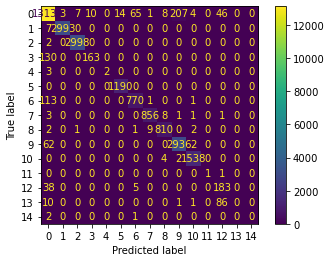